In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import xarray as xr # for handling climate data
from pandarallel import pandarallel # for running pandas functions in parallel
import multiprocessing # for general parallelizing of codes
import tqdm # for having progres bar
from functools import partial # for full control over handling function arguemnts
pandarallel.initialize(nb_workers=multiprocessing.cpu_count()-1)
import pandas as pd

INFO: Pandarallel will run on 23 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
from netCDF4 import Dataset
data = Dataset('./InputData/coarse_tmmn.nc')
from netCDF4 import date2index
from datetime import datetime
timeindex = date2index(datetime(2009, 1, 15),
                       data.variables['day'])
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lon, lat = np.meshgrid(lon, lat)
temp = data.variables['air_temperature'][timeindex]

<ipython-input-3-9ecaa95a88ba>:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lon, lat, temp,


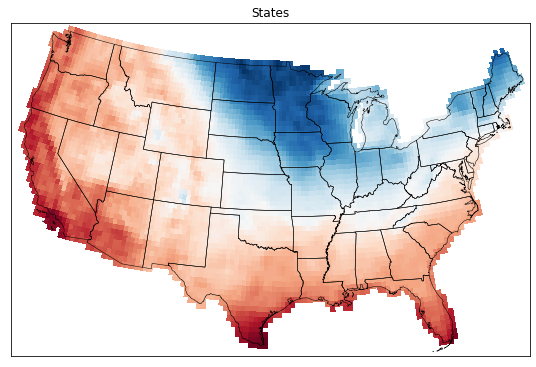

In [3]:
fig = plt.figure(figsize = (9.3, 14.12))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=32,lat_2=49,lon_0=-95)
shp_info = m.readshapefile('./InputData/st99_d00','states',drawbounds=True)
statenames=[]
for shapedict in m.states_info:
    statename = shapedict['NAME']
    statenames.append(statename)
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        poly = Polygon(seg,facecolor=None,edgecolor='black', alpha=0)
        ax.add_patch(poly)
plt.title('States')


m.pcolormesh(lon, lat, temp,
             latlon=True, cmap='RdBu_r',shading="nearest")
#m.shadedrelief(scale=0.5)
#m.drawcoastlines(color='lightgray')

plt.show()

In [4]:
ds_tmin = xr.open_dataset("./InputData/coarse_tmmn.nc")

In [5]:
lon_bins = ds_tmin.lon.values
lon_bins = np.append(lon_bins, 2 * lon_bins[-1] - lon_bins[-2] )

In [6]:
lat_bins = ds_tmin.lat.values
lat_bins = np.append(lat_bins, 2 * lat_bins[-1] - lat_bins[-2] )
lat_bins = np.flip(lat_bins)

In [7]:
#reading data
gowalla_checkin_df = pd.read_csv('./Data/all_feat_gowalla.csv', delimiter=",",
                                    error_bad_lines =False).sample(frac=0.1)

In [8]:
gowalla_checkin_df_US = gowalla_checkin_df[gowalla_checkin_df["country"]=="USA"]

In [9]:
gowalla_checkin_df_lat_binned = gowalla_checkin_df_US.assign(
    lat_cut=pd.cut(gowalla_checkin_df_US.latitude, lat_bins).apply(lambda x : x.left),
    lon_cut=pd.cut(gowalla_checkin_df_US.longitude, lon_bins).apply(lambda x : x.left)
)

In [10]:
gowalla_checkin_df_lat_binned["cartesian"] = gowalla_checkin_df_lat_binned.parallel_apply(lambda row: tuple([row.lat_cut, row.lon_cut]),axis=1)

In [11]:
cartesian_count = gowalla_checkin_df_lat_binned.groupby("cartesian").size().reset_index()

In [12]:
cartesian_count["lat"]=cartesian_count["cartesian"].parallel_apply(lambda x : x[0])
cartesian_count["lon"]=cartesian_count["cartesian"].parallel_apply(lambda x : x[1])

In [13]:
cartesian_count.drop(columns="cartesian",inplace=True)

In [14]:
#cartesian_count = cartesian_count.loc[(cartesian_count["lat"].isna())] 
cartesian_count.dropna(inplace=True)

In [15]:
cartesian_count.sort_values(by = ["lat","lon"], ascending = [True, True])

,0,lat,lon
0,20,24.838,-80.829
1,4,24.838,-80.412
3,8,25.150,-80.829
4,5,25.150,-80.412
5,72,25.462,-80.829
...,...,...,...
3227,3,48.379,-93.746
2951,25,48.796,-122.912
2879,16,48.796,-122.496
2952,1,48.796,-122.079


In [16]:
cartesian_count_np=cartesian_count.pivot(index = "lat", columns="lon").to_numpy()

In [17]:
def pad(array, reference_shape, offsets):
    """
    array: Array to be padded
    reference_shape: tuple of size of ndarray to create
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    will throw a ValueError if offsets is too big and the reference_shape cannot handle the offsets
    """

    # Create an array of zeros with the reference shape
    result = np.zeros(reference_shape)
    # Create a list of slices from offset to offset + shape in each dimension
    insertHere = [slice(offsets[dim], offsets[dim] + array.shape[dim]) for dim in range(array.ndim)]
    # Insert the array in the result at the specified offsets
    result[insertHere] = array
    return result

In [18]:
#cartesian_count_np =pad(cartesian_count_np, [139, 59], [0,0])

In [19]:
cartesian_count_np.shape

(59, 137)

In [20]:
my_zero_col=np.zeros([cartesian_count_np.shape[0],1])
my_zero_col.shape

(59, 1)

In [21]:
cartesian_count_np_new = np.hstack([my_zero_col, cartesian_count_np])

In [22]:
cartesian_count_np_new = np.hstack([cartesian_count_np_new, my_zero_col])
#cartesian_count_np_new = np.hstack([cartesian_count_np_new, my_zero_col])

<ipython-input-26-e83844313561>:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lon, lat, np.flip(cartesian_count_np_new,0),


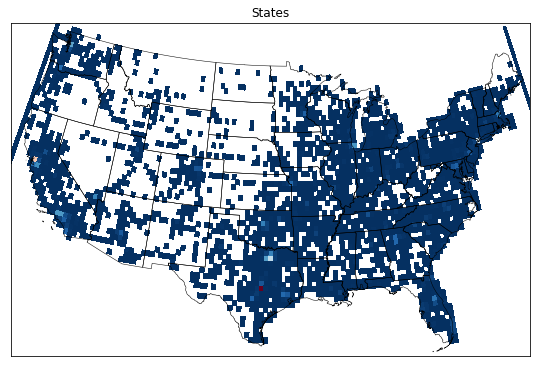

In [26]:

plt.show()
fig = plt.figure(figsize = (9.3, 14.12))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=32,lat_2=49,lon_0=-95)
shp_info = m.readshapefile('./InputData/st99_d00','states',drawbounds=True)
statenames=[]
for shapedict in m.states_info:
    statename = shapedict['NAME']
    statenames.append(statename)
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        poly = Polygon(seg,facecolor=None,edgecolor='black', alpha=0)
        ax.add_patch(poly)
plt.title('States')


m.pcolormesh(lon, lat, np.flip(cartesian_count_np_new,0),
             latlon=True, cmap='RdBu_r',shading="nearest")
#m.shadedrelief(scale=0.5)
#m.drawcoastlines(color='lightgray')
plt.show()

In [ ]:
#reading data
brightkite_checkin_df = pd.read_csv('./Data/all_feat_bright.csv', delimiter=",",
                                    error_bad_lines =False).sample(frac=0.1)

In [ ]:
brightkite_checkin_df_US = brightkite_checkin_df[brightkite_checkin_df["country"]=="USA"]

In [ ]:
brightkite_checkin_df_lat_binned = brightkite_checkin_df_US.assign(
    lat_cut=pd.cut(brightkite_checkin_df_US.latitude, lat_bins).apply(lambda x : x.left),
    lon_cut=pd.cut(brightkite_checkin_df_US.longitude, lon_bins).apply(lambda x : x.left)
)

In [ ]:
brightkite_checkin_df_lat_binned["cartesian"] = brightkite_checkin_df_lat_binned.parallel_apply(lambda row: tuple([row.lat_cut, row.lon_cut]),axis=1)

In [ ]:
cartesian_count = brightkite_checkin_df_lat_binned.groupby("cartesian").size().reset_index()

In [ ]:
cartesian_count["lat"]=cartesian_count["cartesian"].parallel_apply(lambda x : x[0])
cartesian_count["lon"]=cartesian_count["cartesian"].parallel_apply(lambda x : x[1])

In [ ]:
cartesian_count.drop(columns="cartesian",inplace=True)

In [ ]:
#cartesian_count = cartesian_count.loc[(cartesian_count["lat"].isna())] 
cartesian_count.dropna(inplace=True)

In [ ]:
cartesian_count.sort_values(by = ["lat","lon"], ascending = [True, True])

In [ ]:
cartesian_count_np=cartesian_count.pivot(index = "lat", columns="lon").to_numpy()

In [ ]:
def pad(array, reference_shape, offsets):
    """
    array: Array to be padded
    reference_shape: tuple of size of ndarray to create
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    will throw a ValueError if offsets is too big and the reference_shape cannot handle the offsets
    """

    # Create an array of zeros with the reference shape
    result = np.zeros(reference_shape)
    # Create a list of slices from offset to offset + shape in each dimension
    insertHere = [slice(offsets[dim], offsets[dim] + array.shape[dim]) for dim in range(array.ndim)]
    # Insert the array in the result at the specified offsets
    result[insertHere] = array
    return result

In [ ]:
#cartesian_count_np =pad(cartesian_count_np, [139, 59], [0,0])

In [ ]:
cartesian_count_np.shape

In [ ]:
my_zero_col=np.zeros([cartesian_count_np.shape[0],1])
my_zero_col.shape

In [ ]:
cartesian_count_np = np.hstack([my_zero_col, cartesian_count_np])

In [ ]:
cartesian_count_np = np.hstack([cartesian_count_np, my_zero_col])

In [ ]:
fig = plt.figure(figsize = (9.3, 14.12))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=32,lat_2=49,lon_0=-95)
shp_info = m.readshapefile('./InputData/st99_d00','states',drawbounds=True)
statenames=[]
for shapedict in m.states_info:
    statename = shapedict['NAME']
    statenames.append(statename)
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        poly = Polygon(seg,facecolor=None,edgecolor='black', alpha=0)
        ax.add_patch(poly)
plt.title('States')


m.pcolormesh(lon, lat, np.flip(cartesian_count_np,0),
             latlon=True, cmap='RdBu_r',shading="nearest")
#m.shadedrelief(scale=0.5)
#m.drawcoastlines(color='lightgray')

plt.show()